[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/arampacha/nn4tab/blob/master/_example_adult.ipynb)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

from pathlib import Path
from tqdm import tqdm
import gc
from pandas.api.types import is_categorical_dtype, is_numeric_dtype

# Data

In [ ]:
from nn4tab.data import DataLoader, TabularDataset, get_dsets, cont_cat_split
from nn4tab.data import Normalize, FillMissing, Categorify

In [ ]:
df = pd.read_csv(Path('./datasets/adult.csv'))

In [ ]:
tmp = df[['education', 'education-num']].groupby('education', as_index=False).agg('mean')

In [ ]:
mgd = df[['education', 'education-num']].merge(tmp, how='left', on='education')
(mgd['education-num_x'] - mgd['education-num_y']).sum()

0.0

In [ ]:
df['education-num'] = mgd['education-num_y']

In [ ]:
df['salary'] = (df['salary'].apply(lambda x: x=='>=50k')).astype(np.int8)

In [ ]:
del tmp, mgd
gc.collect()

285

In [ ]:
dep_var = ['salary']
cont, cat = cont_cat_split(df, dep_var, max_card=10)

In [ ]:
cont, cat

(['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

In [ ]:
procs = [Normalize, FillMissing, Categorify]
train_ds, valid_ds = get_dsets(df, cont, cat, dep_var, procs=procs)

In [ ]:
train_ds[0]

(array([ 6, 11,  5,  4,  5,  3,  1, 29]),
 array([-0.9890163 ,  0.15597549, -0.80343074, -0.14422642, -0.21821396,
        -0.0333842 ], dtype=float32),
 array([0.], dtype=float32))

In [ ]:
from nn4tab.data import get_dl

In [ ]:
train_dl = get_dl(train_ds)
valid_dl = get_dl(valid_ds, train=False)

In [ ]:
x_cat, x_cont, y = next(iter(train_dl))

x_cat.shape, x_cont.shape, y.shape

(torch.Size([512, 8]), torch.Size([512, 6]), torch.Size([512, 1]))

# Model

In [ ]:
from nn4tab.model import TabularModel, get_tabular_model

In [ ]:
model = get_tabular_model(train_ds, cont, cat, 1, [100, 50])

In [ ]:
x_cat = x_cat.type(torch.long)

In [ ]:
pred = model(x_cat, x_cont)

In [ ]:
pred.shape

torch.Size([512, 1])

In [ ]:
nn.BCEWithLogitsLoss()(pred, y)

tensor(0.7462, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)

# Training

In [ ]:
from nn4tab.learner import LearnerV0, accuracy_binary

In [ ]:
def get_dataloaders():
    return get_dl(train_ds), get_dl(valid_ds)

In [ ]:
dataloaders = get_dataloaders()
tab_nn = get_tabular_model(train_ds, cont, cat, 1, [100, 50])

In [ ]:
learn = LearnerV0(tab_nn, dataloaders, torch.optim.Adam, nn.BCEWithLogitsLoss(), metrics=accuracy_binary)

In [ ]:
learn.fit(2)

epoch 2: valid loss 0.3239, accuracy 0.8483: 100%|█████████████████████| 12/12 [00:11<00:00,  1.02it/s]


In [ ]:
def plot_losses(learn):
    fig, ax = plt.subplots(figsize=(8,5))
    plt.plot(learn.train_losses.values)
    xvl = [(i+1)*len(learn.train_dl) for i in range(learn.epoch+1)]
    plt.plot(xvl, learn.valid_losses.avgs)
    ax.set_xlabel('Batches')
    ax.set_ylabel('Loss')
    plt.legend(['Train loss', 'Validation loss'])
    return ax

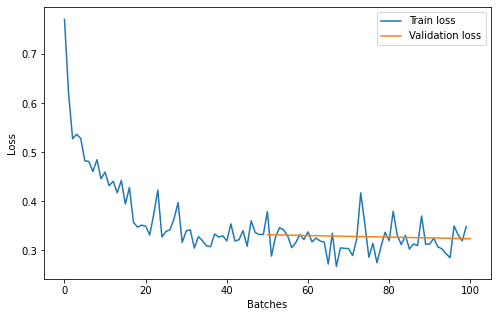

In [ ]:
plot_losses(learn);